<h1>Importing Libaries</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import re
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aajay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aajay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h2>Importing datasets</h2>

In [3]:
#data path
train_path = "D:/Machine learning project/movie genere classification/Genre Classification Dataset/train_data.txt"
test_path = "D:/Machine learning project/movie genere classification/Genre Classification Dataset/test_data.txt"
test_s_path = "D:/Machine learning project/movie genere classification/Genre Classification Dataset/test_data_solution.txt"

In [4]:
train_data = pd.read_csv(train_path, sep= ':::', names= ["Title", "Genre", "Description"], engine= 'python')

In [5]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
#test data
test_data = pd.read_csv(test_path, sep=':::', names=["ID","Title", "Description"], engine='python')
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [7]:
#test_solution data
test_solution_data = pd.read_csv(test_s_path, sep=':::', names=["ID", "Title", "Genre", "Description"], engine='python')
test_solution_data.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


<h1>Data Preprocessing</h1>

In [8]:
train_data_Size = train_data.shape
print(f"The train data size is {train_data_Size}")
test_data_size = test_data.shape
print(f"The test data size is {test_data_size}")

The train data size is (54214, 3)
The test data size is (54200, 3)


In [9]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [11]:
#checking null values in train data
total = train_data.isnull().sum()
total

Title          0
Genre          0
Description    0
dtype: int64

<h1>EDA(Exploratory Data Analysis)</h1>

C:\Users\aajay\AppData\Local\Temp\ipykernel_2232\1038469996.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(data= train_data, y = 'Genre' , hue= None,  order= train_data['Genre'].value_counts().index , palette= 'Set3')


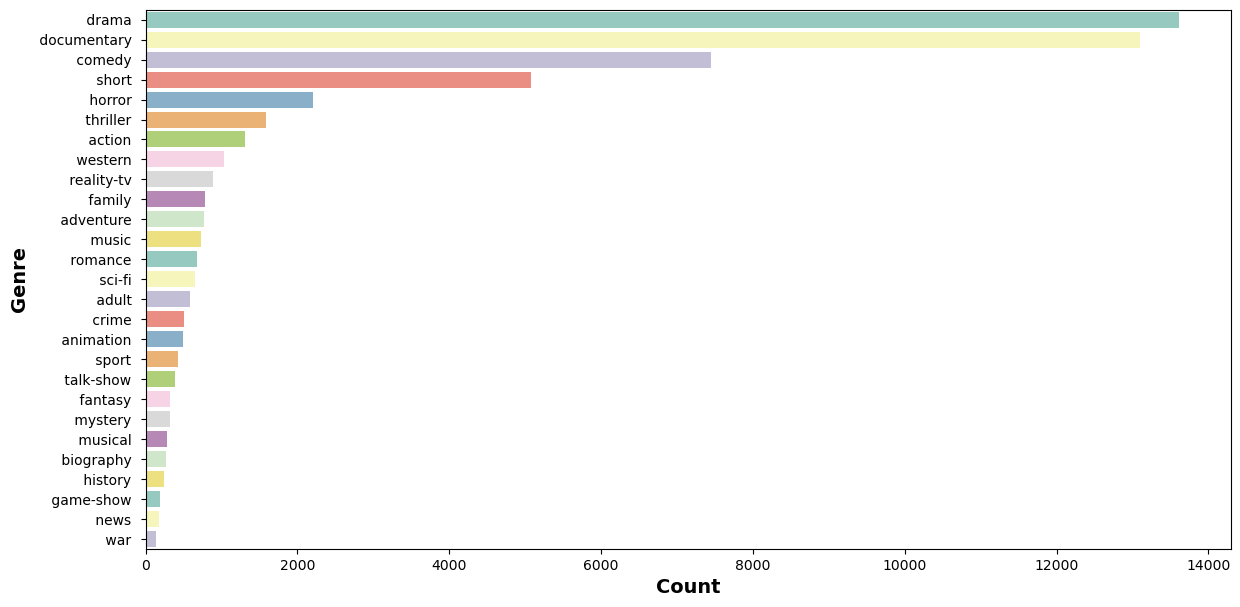

The different type of genre is 27


In [12]:
#Visulize the data using matplot and seaborn
plt.figure(figsize=(14, 7))
sn.countplot(data= train_data, y = 'Genre' , hue= None,  order= train_data['Genre'].value_counts().index , palette= 'Set3')
plt.xlabel("Count", fontsize = 14, fontweight = 'bold')
plt.ylabel("Genre", fontsize = 14, fontweight = 'bold')
plt.show()
print(f"The different type of genre is {len(np.unique(train_data['Genre']))}")

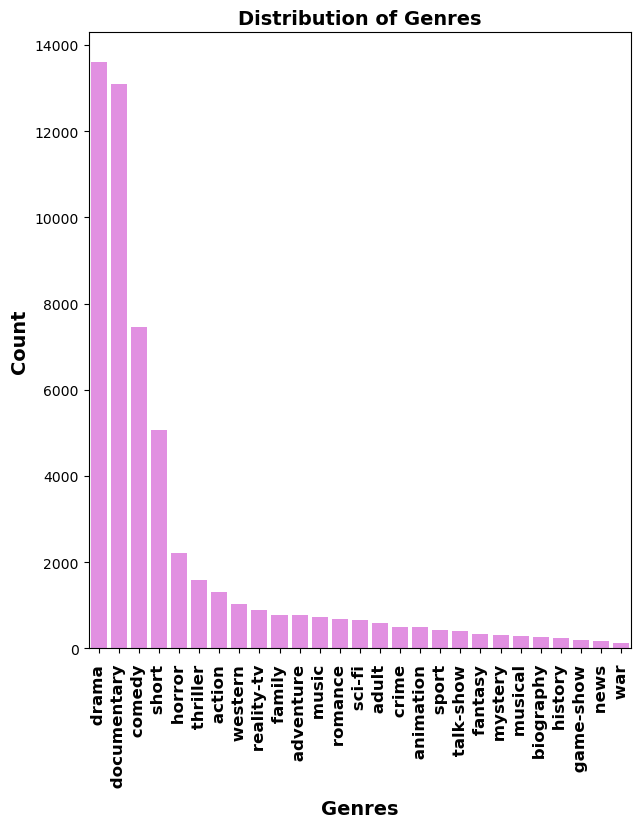

In [13]:
plt.figure(figsize=(7,8))
counts = train_data['Genre'].value_counts()
sn.barplot(x = counts.index, y = counts, color= 'violet')
plt.title("Distribution of Genres", fontsize = 14, fontweight = 'bold')
plt.xlabel("Genres", fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 90 , fontsize = 12, fontweight = 'bold')
plt.ylabel("Count", fontsize = 14, fontweight = 'bold')
plt.show()

In [14]:
#To check description length
train_data['D_length'] = train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,D_length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


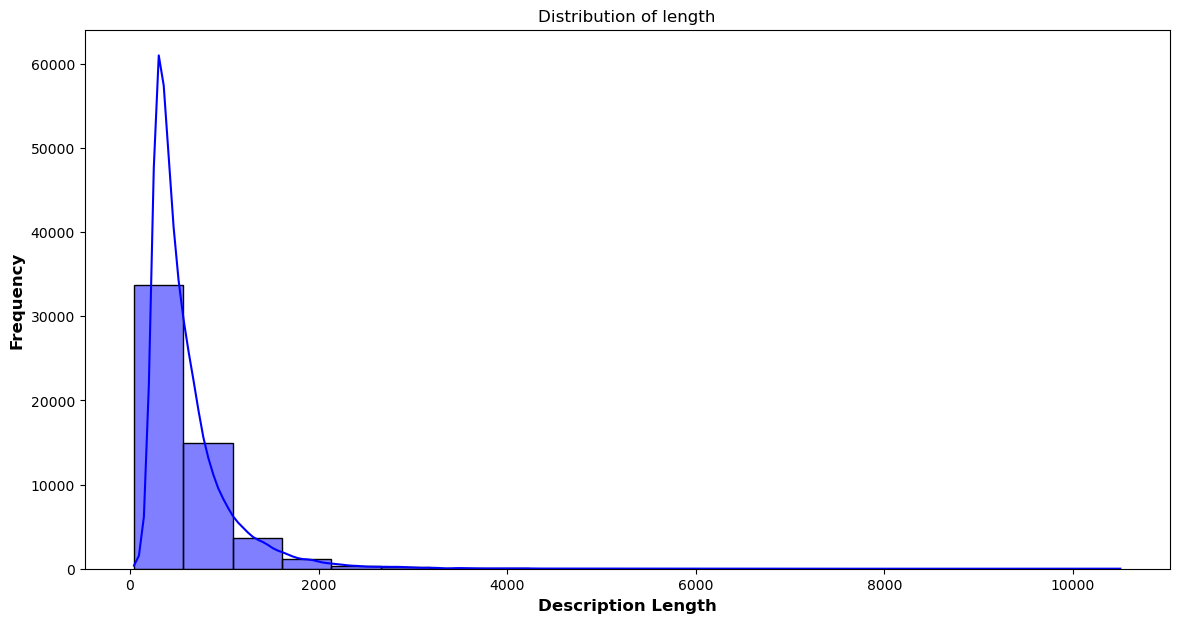

In [15]:
plt.figure(figsize=(14, 7))
sn.histplot(data=train_data['D_length'], bins= 20, color= 'blue', kde= 'True')
plt.xlabel("Description Length", fontsize = 12, fontweight = 'bold' )
plt.ylabel("Frequency", fontsize = 12, fontweight = 'bold' )
plt.title("Distribution of length")
plt.show()


<h1>Data Cleaning and preprocessing</h1>

In [16]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('-', ' ', text.lower())
    text = re.sub(f'[{string.digits}]', ' ', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text, language = 'english', preserve_line = True)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text = re.sub("\s[\s]+", ' ', text).strip()
    return re.sub(f'[{re.escape(string.punctuation)}]', '', text)


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aajay\AppData\Local\Temp\ipykernel_2232\951199757.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s[\s]+", ' ', text).strip()


In [17]:
train_data['cleaned_d'] = train_data['Description'].apply(clean_text)
test_data['cleaned_d'] = test_data['Description'].apply(clean_text)
test_solution_data['cleaned_d'] = test_solution_data['Description'].apply(clean_text)



In [18]:
train_data.head()

,Title,Genre,Description,D_length,cleaned_d
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [19]:
test_data.head()

,ID,Title,Description,cleaned_d
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...


In [20]:
test_solution_data.head()

,ID,Title,Genre,Description,cleaned_d
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...


In [21]:
#length cleaned data
train_data['len_clean_txt'] = train_data['cleaned_d'].apply(len)
test_data['len_clean_txt'] = test_data['cleaned_d'].apply(len)


In [22]:
train_data.head()

,Title,Genre,Description,D_length,cleaned_d,len_clean_txt
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


In [23]:
test_data.head()

,ID,Title,Description,cleaned_d,len_clean_txt
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...,240
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...,409
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...,327
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...,356
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...,453


In [24]:
#To check length of cleaned description
train_data['len__clean_txt'] = train_data['cleaned_d'].apply(len)
test_data['len__clean_txt'] = test_data['cleaned_d'].apply(len)


In [25]:
train_data.head()

,Title,Genre,Description,D_length,cleaned_d,len_clean_txt,len__clean_txt
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282,282


In [26]:
test_data.head()

,ID,Title,Description,cleaned_d,len_clean_txt,len__clean_txt
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...,240,240
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...,409,409
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...,327,327
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...,356,356
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...,453,453


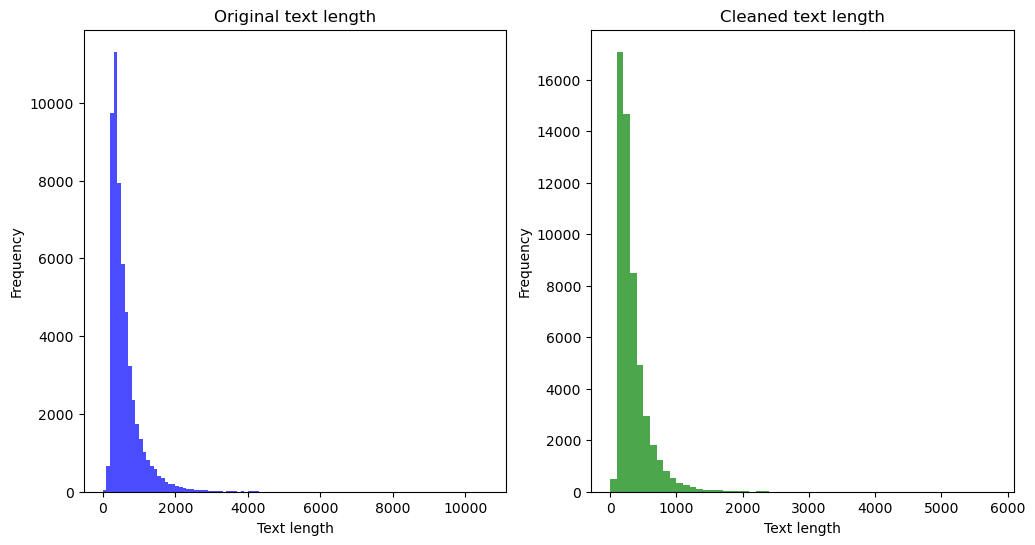

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
original_l = train_data['D_length']
plt.hist(original_l, bins= range(0, max(original_l)+100, 100), color = 'blue', alpha = 0.7)
plt.xlabel("Text length")
plt.ylabel("Frequency")
plt.title("Original text length")

plt.subplot(1, 2, 2)
original_l = train_data['len__clean_txt']
plt.hist(original_l, bins= range(0, max(original_l)+100, 100), color = 'green', alpha = 0.7)
plt.xlabel("Text length")
plt.ylabel("Frequency")
plt.title("Cleaned text length")
plt.show()

In [28]:
#remove the length description 
(train_data['len__clean_txt'] > 2000).value_counts()

len__clean_txt
False    54131
True        83
Name: count, dtype: int64

In [29]:
print('Dataframe size before  removal:', len(train_data))
filt = train_data['len__clean_txt']> 2000
train_data.drop(train_data[filt].index, axis= 0 , inplace= True)
print('Dataframe size after  removal:', len(train_data))
print(f"Removed rows : {filt.sum()}")

Dataframe size before  removal: 54214
Dataframe size after  removal: 54131
Removed rows : 83


C:\Users\aajay\AppData\Local\Temp\ipykernel_2232\3142753524.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x = 'Genre' ,y = 'len__clean_txt' ,data = train_data, palette= 'Set2')


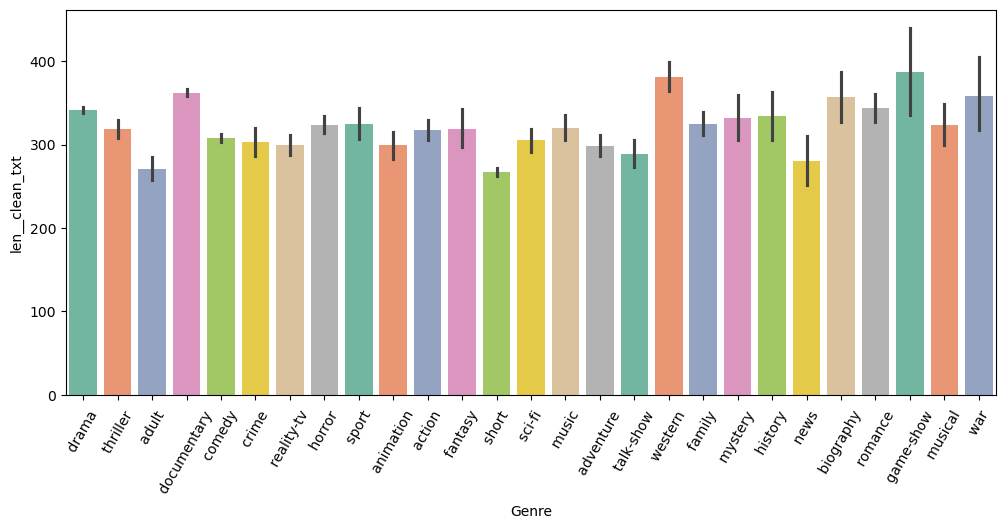

In [30]:
plt.figure(figsize = (12,5))
sn.barplot(x = 'Genre' ,y = 'len__clean_txt' ,data = train_data, palette= 'Set2') 
plt.xticks(rotation = 60)
plt.show()

<h1>Text Tokenization and Vectorization</h1>

<h2>Text Vecotrizer</h2>

In [31]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words = num_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(train_data['cleaned_d'].values)

<>:3: SyntaxWarning: invalid escape sequence '\]'
<>:3: SyntaxWarning: invalid escape sequence '\]'
C:\Users\aajay\AppData\Local\Temp\ipykernel_2232\3854886260.py:3: SyntaxWarning: invalid escape sequence '\]'
  tokenizer = Tokenizer(num_words = num_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)


In [32]:
X = tokenizer.texts_to_sequences(train_data['cleaned_d'].values)
X = pad_sequences(X, maxlen= max_len)
y = pd.get_dummies(train_data['Genre']).values
X_test = tokenizer.texts_to_sequences(test_data['cleaned_d'].values)
y_test = pd.get_dummies(test_solution_data['Genre']).values

In [33]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data['cleaned_d'])
X_test = tfidf_vectorizer.transform(test_data['cleaned_d'])

<h2>Build LSTM model</h2>

In [34]:
Embedding_dim = 100
model = Sequential()
model.add(Embedding(num_words, Embedding_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout= 0.2))
model.add(Dense(27, activation= "softmax"))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

C:\Users\aajay\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<h2>Split data</h2>

In [35]:
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state= 42)

In [36]:
NaiveModel = MultinomialNB()
NaiveModel.fit(X_train, y_train)

MultinomialNB()

In [37]:
y_pred = NaiveModel.predict(X_val)

<h2>Model Accuracy</h2>

In [40]:
Accuracy = accuracy_score(y_val, y_pred)
print(f"The validation Accuracy: {Accuracy}")
print("The classification Report:", classification_report(y_val, y_pred))

The validation Accuracy: 0.43585480742587973


C:\Users\aajay\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aajay\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The classification Report:                precision    recall  f1-score   support

      action        0.00      0.00      0.00       254
       adult        0.00      0.00      0.00       105
   adventure        0.00      0.00      0.00       134
   animation        0.00      0.00      0.00       101
   biography        0.00      0.00      0.00        45
      comedy        0.72      0.02      0.04      1505
       crime        0.00      0.00      0.00       116
 documentary        0.51      0.89      0.65      2605
       drama        0.38      0.86      0.53      2732
      family        0.00      0.00      0.00       158
     fantasy        0.00      0.00      0.00        65
   game-show        0.00      0.00      0.00        48
     history        0.00      0.00      0.00        47
      horror        0.00      0.00      0.00       434
       music        0.00      0.00      0.00       145
     musical        0.00      0.00      0.00        57
     mystery        0.00      0.00   

C:\Users\aajay\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
